In [ ]:
import random
import os
import numpy as np
from numpy.random import seed
import pandas as pd
from scipy import signal
from scipy.io import wavfile as wav

import matplotlib.pyplot as plt
import IPython.display as ipd

# Classification tools
from sklearn.svm import SVC
from sklearn.preprocessing import scale, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from sklearn.decomposition import PCA

# Advanced audio features
import librosa
import librosa.display as lid
from librosa.feature import melspectrogram, mfcc,chroma_stft
from librosa.display import specshow
# Frequency analysis
from scipy.fft import fft, fftfreq, rfft, rfftfreq
from scipy.signal import spectrogram

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import pickle

import tensorflow as tf
from tensorflow import keras
from keras import Sequential, Model
from keras import layers, regularizers
from keras.layers import Input, Flatten, Dense, Dropout, Reshape, Rescaling, LeakyReLU, Lambda, Concatenate, LSTM, Conv1D, Conv2D, MaxPooling1D

!pip install datasets
from datasets import Dataset, Features, Array2D

!pip install visualkeras
import visualkeras

cherrypicked_seed = 420
seed(cherrypicked_seed)
tf.random.set_seed(cherrypicked_seed)
random.seed(cherrypicked_seed)

#!pip install spec_augment
#!pip install audiomentations
#from audiomentations import Compose, AddGaussianNoise, PitchShift, Shift
#from spec_augment import SpecAugment
#import kapre

import cv2
import glob
from keras.preprocessing.image import ImageDataGenerator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 4.6 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.2/992.2 KB 25.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load dataset

In [ ]:
! pip install -q kaggle
from google.colab import files

# upload kaggle.json [info at: https://www.kaggle.com/general/74235]
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download 'andradaolteanu/gtzan-dataset-music-genre-classification'

import zipfile
with zipfile.ZipFile('gtzan-dataset-music-genre-classification.zip', 'r') as zip_ref:
    zip_ref.extractall('gtzan')

Saving kaggle.json to kaggle.json
100% 1.21G/1.21G [00:32<00:00, 41.1MB/s]
100% 1.21G/1.21G [00:33<00:00, 39.4MB/s]


# Explore dataframe

In [ ]:
base_path = 'gtzan/Data/'
audio_path = base_path+'genres_original/'

In [ ]:
df = pd.read_csv(base_path+'features_30_sec.csv')
df.filename = df.apply(lambda x: audio_path+x.label+'/'+x.filename, axis=1)
df

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,gtzan/Data/genres_original/blues/blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,gtzan/Data/genres_original/blues/blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,gtzan/Data/genres_original/blues/blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,gtzan/Data/genres_original/blues/blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,gtzan/Data/genres_original/blues/blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,gtzan/Data/genres_original/rock/rock.00095.wav,661794,0.352063,0.080487,0.079486,0.000345,2008.149458,282174.689224,2106.541053,88609.749506,...,45.050526,-13.289984,41.754955,2.484145,36.778877,-6.713265,54.866825,-1.193787,49.950665,rock
996,gtzan/Data/genres_original/rock/rock.00096.wav,661794,0.398687,0.075086,0.076458,0.000588,2006.843354,182114.709510,2068.942009,82426.016726,...,33.851742,-10.848309,39.395096,1.881229,32.010040,-7.461491,39.196327,-2.795338,31.773624,rock
997,gtzan/Data/genres_original/rock/rock.00097.wav,661794,0.432142,0.075268,0.081651,0.000322,2077.526598,231657.968040,1927.293153,74717.124394,...,33.597008,-12.845291,36.367264,3.440978,36.001110,-12.588070,42.502201,-2.106337,29.865515,rock
998,gtzan/Data/genres_original/rock/rock.00098.wav,661794,0.362485,0.091506,0.083860,0.001211,1398.699344,240318.731073,1818.450280,109090.207161,...,46.324894,-4.416050,43.583942,1.556207,34.331261,-5.041897,47.227180,-3.590644,41.299088,rock


In [ ]:
labels = list(set(df.label))

n_classes = len(labels)

labels_dict = {lb:ilb for ilb,lb in enumerate(labels)}
df['int_label'] = df.label.apply(lambda l: labels_dict[l])

In [ ]:
for i,f in enumerate(df.filename):
  try: 
    wav.read(f)
  except:
    print(i,f)

554 gtzan/Data/genres_original/jazz/jazz.00054.wav


In [ ]:
df = df.drop(df[df.filename=='gtzan/Data/genres_original/jazz/jazz.00054.wav'].index)

In [ ]:
fig = px.histogram(df.label,title='Class distribution',color=df.label)
fig.show()

(array([305., 650.,   7.,   6.,   4.,  10.,   5.,   2.,   0.,  10.]),
 array([660000. , 661580.8, 663161.6, 664742.4, 666323.2, 667904. ,
        669484.8, 671065.6, 672646.4, 674227.2, 675808. ]),
 <a list of 10 Patch objects>)

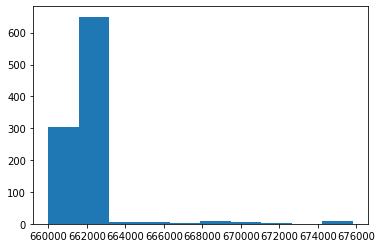

In [ ]:
plt.hist([len(wav.read(f)[1]) for f in df.filename])

# Utils

In [ ]:
def play_nparr(arr, rate=22050):
  tmp = 'test1.wav'
  wav.write(tmp, rate, arr)
  ipd.Audio(tmp)

def save_pkl(filename, obj):
  with open(filename, 'wb') as f:
    pickle.dump(obj, f)

def load_pkl(filename):
  with open(filename, 'rb') as f:
    obj = pickle.load(f)
  return obj
  
def plot_history(history):
  fig = make_subplots(rows = 1, cols = 2, subplot_titles = ["Loss", "Accuracy"])
  fig.add_trace(go.Scatter(y = history.history['val_loss'], name = "val_loss"), row = 1, col = 1,)
  fig.add_trace(go.Scatter(y = history.history['loss'], name = "loss"), row = 1, col = 1,)
  fig.add_trace(go.Scatter(y = history.history['val_accuracy'], name = "val accuracy"), row = 1, col = 2,)
  fig.add_trace(go.Scatter(y = history.history['accuracy'], name = "accuracy"), row = 1, col = 2,)
  # Set x-axis title
  fig.update_xaxes(title_text = "Epoch")
  # Set y-axes titles
  fig.update_yaxes(title_text = "Loss", row = 1, col = 1)
  fig.update_yaxes(title_text = "Accuracy", row = 1, col = 2)
  fig.show()

In [ ]:
def build_augmentation_section(flip_mode = 'horizontal_and_vertical', rotation_range = 0.2):
  data_augmentation = Sequential([
    layers.RandomFlip(mode = flip_mode),
    layers.RandomRotation(rotation_range),
    # tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.5, 0.5), width_factor=(-0.5, 0.5), interpolation="bilinear", fill_mode="constant", fill_value=255.0, seed=cherrypicked_seed),
    # tf.keras.layers.RandomBrightness((-0.25, 0.25), value_range=(0, 255), seed=cherrypicked_seed),
    # tf.keras.layers.RandomContrast(0.25, seed=cherrypicked_seed)
  ])
  return data_augmentation

def build_input_section(inputs, preprocess_input_layer, do_normalization = False, do_augmentation = True):
  if do_normalization:
    inputs = Rescaling(1./255)(inputs)
  if do_augmentation:
    inputs = build_augmentation_section()(inputs)
  outputs = preprocess_input_layer(inputs)
  return outputs

def build_output_section(inputs, n_classes, activation = 'relu', output_activation = 'softmax'):
  x = layers.GlobalAveragePooling2D()(inputs) 
  x = Dense(512, activation = activation, kernel_regularizer = regularizers.l2(), bias_regularizer= regularizers.l2())(x)
  x = Dropout(0.2)(x)
  x = Dense(256, activation = activation, kernel_regularizer = regularizers.l2(), bias_regularizer= regularizers.l2())(x)
  x = Dropout(0.1)(x)
  x = Dense(128, activation = activation, kernel_regularizer = regularizers.l2(), bias_regularizer= regularizers.l2())(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation = activation)(x)
  outputs = Dense(n_classes, activation = output_activation)(x)
  return outputs

def trim_model(model, layer_name): 
  return Model(inputs = model.input, outputs = model.get_layer(layer_name).output)

def freeze_model(model, freeze_until_layer=None):
  freeze_until_idx = [i for i,layer in enumerate(model.layers) if layer.name==freeze_until_layer][0] if freeze_until_layer!=None else len(model.layers)+1
  for layer_idx,layer in enumerate(model.layers):
    layer.trainable = False if layer_idx <= freeze_until_idx else True
  return model

# Use dataframe features with SVM

In [ ]:
X = df[df.columns[2:-2]].to_numpy()

y_dict = {yk:yi for yi,yk in enumerate(set(df.label))}
y = np.stack([y_dict[y] for y in df.label])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y, random_state=cherrypicked_seed)

In [ ]:
type(x_train)
x_train
#x_train=x_train[:-2]  

array([[ 4.20887232e-01,  8.31286535e-02,  1.45182267e-01, ...,
         7.03708344e+01, -6.06337905e-01,  7.48833466e+01],
       [ 3.90931964e-01,  8.73261467e-02,  7.62890950e-02, ...,
         4.52591171e+01, -2.61247039e+00,  5.96447563e+01],
       [ 4.40995067e-01,  8.24743584e-02,  1.22678056e-01, ...,
         4.75570755e+01, -9.93488848e-01,  4.11933174e+01],
       ...,
       [ 3.79948884e-01,  9.83867049e-02,  1.51299477e-01, ...,
         3.94400902e+01,  6.52951062e-01,  3.59741478e+01],
       [ 3.14549685e-01,  8.57955590e-02,  1.07258856e-01, ...,
         4.06139603e+01, -4.71273279e+00,  7.30589676e+01],
       [ 2.76492238e-01,  8.75471979e-02,  4.87620570e-02, ...,
         1.12863571e+02, -4.94698477e+00,  9.60856934e+01]])

In [ ]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
clf = SVC()
clf.fit(x_train, y_train)

SVC()

In [ ]:
y_pred = clf.predict(x_test)

              precision    recall  f1-score   support

           0       0.60      0.60      0.60        30
           1       0.67      0.73      0.70        30
           2       0.81      0.97      0.88        30
           3       0.91      0.67      0.77        30
           4       0.83      0.80      0.81        30
           5       0.48      0.37      0.42        30
           6       0.63      0.80      0.71        30
           7       0.83      0.63      0.72        30
           8       0.77      0.80      0.79        30
           9       0.80      0.93      0.86        30

    accuracy                           0.73       300
   macro avg       0.73      0.73      0.72       300
weighted avg       0.73      0.73      0.72       300



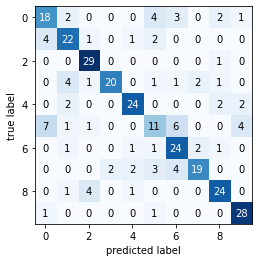

In [ ]:
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
_ = plot_confusion_matrix(cm)

# Feature extractors

In [ ]:
def identity(input):
    return input

def mfcc(input, rate=22050, min_len=40, sampling=1):
    # Compute MFCC coefficients
    mfcc = librosa.feature.mfcc(input*1.0, sr=rate, n_mfcc=128)
    # Add additional necessary zeroes to reach the required length
    pad_width = min_len - mfcc.shape[1]
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant') if pad_width>0 else mfcc
    # Flatten into monodimensional vector for the SVM
    # mfcc = mfcc.flatten()
    return mfcc

def mel_spectrogram(input, rate=22050, min_len=40, sampling=1):
    # Compute Mel spectr
    mel = melspectrogram(input*1.0, sr=rate, hop_length=512)
    mel = librosa.amplitude_to_db(mel, ref=np.max)
    # Add additional necessary zeroes to reach the required length
    pad_width = min_len - mel.shape[1]
    mel = np.pad(mel, pad_width=((0, 0), (0, pad_width)), mode='constant') if pad_width>0 else mel
    # Flatten into monodimensional vector for the SVM
    # mel = mel.flatten()
    return mel

def chromagram(input, rate=22050, min_len=40, sampling=1):
   # Compute chroma features
   chr = chroma_stft(input*1.0, sr=rate)
   # Add additional necessary zeroes to reach the required length
   pad_width = min_len - chr.shape[1]
   chr = np.pad(chr, pad_width=((0, 0), (0, pad_width)), mode='constant') if pad_width>0 else chr
   # Flatten into monodimensional vector for the SVM
   # chr = chr.flatten()
   return chr

# Spectrogram visualization (with librosa)
def plot_spectrogram(spec, rate=22050, name = ''):
  specshow(spec, x_axis='time', sr=rate, auto_aspect=True)
  plt.xlabel('Time slots (s)')
  plt.ylabel('Frequencies')
  plt.title('%s Spectrogram'% name)
  plt.colorbar()
  plt.show()

# Data Loader

In [ ]:
# Data loader
def load_data(audio_paths, labels, feature_extractor=identity, normalize=False, trim_first=660000, to_categorical=False, split_audio=1):

    signals = np.stack([wav.read(f)[1][:trim_first] for f in audio_paths])
    if split_audio > 1:
      signals = signals.reshape(split_audio*signals.shape[0], int(signals.shape[1]/split_audio))
      labels = np.stack([[lb for i in range(split_audio)] for lb in labels]).reshape(len(labels)*split_audio)

    features = np.stack([feature_extractor(sig) for sig in signals])

    # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=cherrypicked_seed, stratify=labels)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    X_train = np.stack(X_train) 
    X_test = np.stack(X_test)
    y_train = np.stack(y_train)
    y_test = np.stack(y_test)

    if to_categorical:
        y_train = keras.utils.to_categorical(y_train, n_classes)
        y_test = keras.utils.to_categorical(y_test, n_classes)

    return X_train, X_test, y_train, y_test

# Classic ML

## SVM on MFCC


In [ ]:
X_train_mfcc, X_test_mfcc, y_train_mfcc, y_test_mfcc = load_data(df.filename, df.label, feature_extractor=mfcc, normalize=True, split_audio =10)

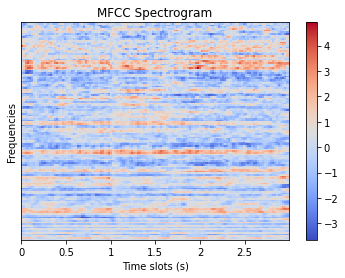

In [ ]:
plot_spectrogram(X_train_mfcc[0], name = 'MFCC')

In [ ]:
X_train_mfcc = np.stack([feat.flatten() for feat in X_train_mfcc])
X_test_mfcc = np.stack([feat.flatten() for feat in X_test_mfcc])

In [ ]:
save_pkl('XYtraintest_mfcc_split10.pickle', (X_train_mfcc, X_test_mfcc, y_train_mfcc, y_test_mfcc))

In [ ]:
scaler = StandardScaler()
x_train_mfcc = scaler.fit_transform(X_train_mfcc)
x_test_mfcc = scaler.transform(X_test_mfcc)

In [ ]:
clf_MFCC = SVC()
clf_MFCC.fit(x_train_mfcc, y_train_mfcc)

SVC()

In [ ]:
y_pred_mfcc = clf_MFCC.predict(x_test_mfcc)

              precision    recall  f1-score   support

       blues       0.69      0.78      0.73       200
   classical       0.79      0.94      0.86       200
     country       0.70      0.71      0.70       200
       disco       0.67      0.55      0.61       200
      hiphop       0.74      0.77      0.75       200
        jazz       0.76      0.71      0.73       198
       metal       0.87      0.94      0.90       200
         pop       0.81      0.85      0.83       200
      reggae       0.76      0.65      0.70       200
        rock       0.54      0.48      0.51       200

    accuracy                           0.74      1998
   macro avg       0.73      0.74      0.73      1998
weighted avg       0.73      0.74      0.73      1998



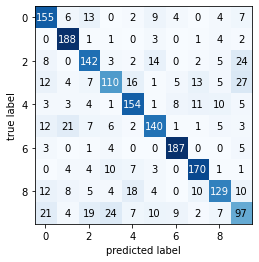

In [ ]:
print(classification_report(y_test_mfcc, y_pred_mfcc))

cm = confusion_matrix(y_test_mfcc, y_pred_mfcc)
_ = plot_confusion_matrix(cm)

## SVM on Mel Spectrogram

In [ ]:
X_train_mel, X_test_mel, y_train_mel, y_test_mel = load_data(df.filename, df.label, feature_extractor=mel_spectrogram, normalize=True, split_audio = 10)

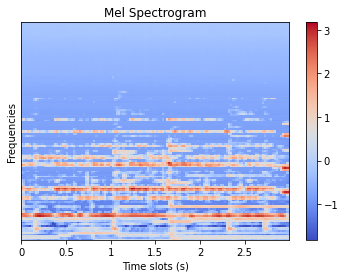

In [ ]:
plot_spectrogram(X_train_mel[0], name = 'Mel')

In [ ]:
X_train_mel = np.stack([feat.flatten() for feat in X_train_mel])
X_test_mel = np.stack([feat.flatten() for feat in X_test_mel])

In [ ]:
save_pkl('XYtraintest_mel_split10.pickle', (X_train_mel, X_test_mel, y_train_mel, y_test_mel))

In [ ]:
scaler = StandardScaler()
x_train_mel = scaler.fit_transform(X_train_mel)
x_test_mel = scaler.transform(X_test_mel)

In [ ]:
clf_MEL = SVC()
clf_MEL.fit(x_train_mel, y_train_mel)

SVC()

In [ ]:
y_pred_mel = clf_MEL.predict(x_test_mel)

              precision    recall  f1-score   support

       blues       0.63      0.69      0.66       200
   classical       0.79      0.86      0.82       200
     country       0.47      0.57      0.52       200
       disco       0.54      0.55      0.54       200
      hiphop       0.58      0.56      0.57       200
        jazz       0.68      0.60      0.64       198
       metal       0.86      0.87      0.86       200
         pop       0.64      0.59      0.62       200
      reggae       0.60      0.53      0.56       200
        rock       0.52      0.47      0.49       200

    accuracy                           0.63      1998
   macro avg       0.63      0.63      0.63      1998
weighted avg       0.63      0.63      0.63      1998



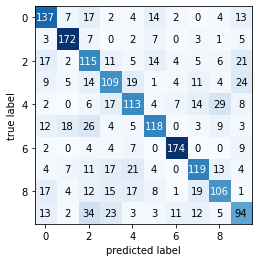

In [ ]:
print(classification_report(y_test_mel, y_pred_mel))

cm = confusion_matrix(y_test_mel, y_pred_mel)
_ = plot_confusion_matrix(cm)

##SVM on Chroma Spectrogram

[ https://blog.paperspace.com/audio-analysis-processing-maching-learning/ ]

In [ ]:
X_train_chr, X_test_chr, y_train_chr, y_test_chr = load_data(df.filename, df.label, feature_extractor=chromagram, normalize=True, split_audio = 10)

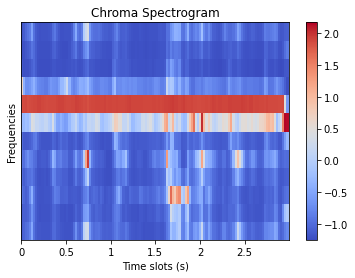

In [ ]:
plot_spectrogram(X_train_chr[0], name = 'Chroma')

In [ ]:
X_train_chr = np.stack([feat.flatten() for feat in X_train_chr])
X_test_chr = np.stack([feat.flatten() for feat in X_test_chr])

In [ ]:
save_pkl('XYtraintest_chr_split10.pickle', (X_train_chr, X_test_chr, y_train_chr, y_test_chr))

In [ ]:
scaler = StandardScaler()
x_train_chr = scaler.fit_transform(X_train_chr)
x_test_chr = scaler.transform(X_test_chr)

In [ ]:
clf_CHR = SVC()
clf_CHR.fit(x_train_chr, y_train_chr)

SVC()

In [ ]:
y_pred_chr = clf_CHR.predict(x_test_chr)

              precision    recall  f1-score   support

       blues       0.32      0.29      0.31       200
   classical       0.56      0.68      0.61       200
     country       0.32      0.42      0.37       200
       disco       0.36      0.36      0.36       200
      hiphop       0.48      0.55      0.51       200
        jazz       0.43      0.42      0.43       198
       metal       0.54      0.64      0.59       200
         pop       0.29      0.19      0.23       200
      reggae       0.38      0.29      0.33       200
        rock       0.31      0.25      0.28       200

    accuracy                           0.41      1998
   macro avg       0.40      0.41      0.40      1998
weighted avg       0.40      0.41      0.40      1998



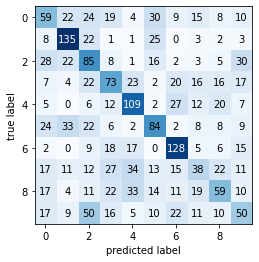

In [ ]:
print(classification_report(y_test_chr, y_pred_chr))

cm = confusion_matrix(y_test_chr, y_pred_chr)
_ = plot_confusion_matrix(cm)


## Combining CHROMA and MFCC

In [ ]:
X_train_comb, X_test_comb, y_train_comb, y_test_comb = load_data(df.filename, df.label, feature_extractor=lambda sig: np.concatenate((mfcc(sig).flatten(), chromagram(sig).flatten())), normalize=True, split_audio= 10)

In [ ]:
X_train_comb.shape

(7992, 18060)

In [ ]:
save_pkl('XYtraintest_comb_split10.pickle', (X_train_comb, X_test_comb, y_train_comb, y_test_comb))

In [ ]:
scaler = StandardScaler()
x_train = scaler.fit_transform(X_train_comb)
x_test = scaler.transform(X_test_comb)

In [ ]:
clf_COMB = SVC()
clf_COMB.fit(x_train, y_train_comb)

SVC()

In [ ]:
y_pred = clf_COMB.predict(x_test)

              precision    recall  f1-score   support

       blues       0.66      0.77      0.71       200
   classical       0.79      0.93      0.85       200
     country       0.68      0.71      0.69       200
       disco       0.68      0.53      0.59       200
      hiphop       0.72      0.75      0.73       200
        jazz       0.74      0.68      0.71       198
       metal       0.86      0.93      0.89       200
         pop       0.82      0.85      0.83       200
      reggae       0.75      0.65      0.69       200
        rock       0.53      0.47      0.50       200

    accuracy                           0.73      1998
   macro avg       0.72      0.73      0.72      1998
weighted avg       0.72      0.73      0.72      1998



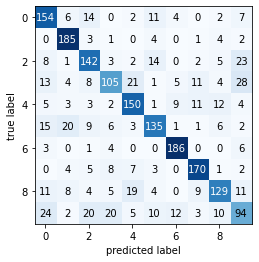

In [ ]:
print(classification_report(y_test_comb, y_pred))

cm = confusion_matrix(y_test_comb, y_pred)
_ = plot_confusion_matrix(cm)

# Deep Learning methods

##CNN on Mel Spectrogram

In [ ]:
mel_path = '/content/drive/MyDrive/Progetto/Audio_files/mel_spectrograms'

In [ ]:
image = cv2.imread(mel_path + '/test/mel_test_00000_7.jpg',cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

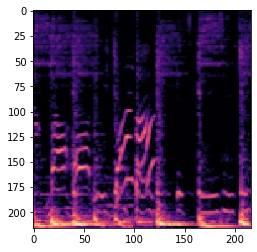

In [ ]:
plt.imshow(image)

In [ ]:
# MEL TRAIN DATASET
X_mel_train = []
y_mel_train = []
for path in glob.glob(mel_path + '/train/*'):
    lbl = path.split("/")[-1].split('.')[0].split('_')[-1]
    image = cv2.imread(path,cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    X_mel_train.append(image)
    y_mel_train.append(lbl)

X_mel_train = np.array(X_mel_train)
y_mel_train = np.array(y_mel_train)
y_mel_train = keras.utils.to_categorical(y_mel_train, n_classes)

In [ ]:
# MEL TEST DATASET
X_mel_test = []
y_mel_test = []
for path in glob.glob(mel_path + '/test/*'):
    lbl = path.split("/")[-1].split('.')[0].split('_')[-1]
    image = cv2.imread(path,cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    X_mel_test.append(image)
    y_mel_test.append(lbl)

X_mel_test = np.array(X_mel_test)
y_mel_test = np.array(y_mel_test)
y_mel_test = keras.utils.to_categorical(y_mel_test, n_classes)

In [ ]:
X_mel_train.shape

(7992, 216, 216, 3)

In [ ]:
_= save_pkl('XYtraintest_mel_split10_notnorm.pickle',(X_mel_train,y_mel_train,X_mel_test,y_mel_test))

In [ ]:
input_shape=X_mel_train.shape[1:]
model = keras.Sequential()

X_input = Input(input_shape)
X_input = Rescaling(1./255.0)(X_input)

X = Conv2D(64,kernel_size=(3,3), strides = (1,1), kernel_regularizer = regularizers.l2(), bias_regularizer= regularizers.l2())(X_input)
X = keras.layers.BatchNormalization(axis=3)(X)
X = keras.layers.Activation('relu')(X)
X = keras.layers.MaxPooling2D((2,2))(X)

X = Dropout(0.2)(X)

X = Conv2D(32,kernel_size=(3,3), kernel_regularizer = regularizers.l2(), bias_regularizer= regularizers.l2())(X)
X = keras.layers.BatchNormalization(axis=-1)(X)
X = keras.layers.Activation('relu')(X)
X = keras.layers.MaxPooling2D((2,2))(X)

X = Dropout(0.2)(X)

X = Conv2D(16,kernel_size=(3,3), kernel_regularizer = regularizers.l2(), bias_regularizer= regularizers.l2())(X)
X = keras.layers.BatchNormalization(axis=-1)(X)
X = keras.layers.Activation('relu')(X)
X = keras.layers.MaxPooling2D((2,2))(X)

X = Flatten()(X)

X = Dense(64, activation='relu', kernel_regularizer = regularizers.l2(), bias_regularizer= regularizers.l2())(X)
X = Dropout(0.1)(X)
X = Dense(n_classes, activation='softmax')(X)

CNN_mel_net = Model(inputs=X_input, outputs=X)

In [ ]:
CNN_mel_net.summary()
#visualkeras.layered_view(model, legend = True, scale_xy=1)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 216, 216, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 214, 214, 64)      1792      
                                                                 
 batch_normalization_5 (Batc  (None, 214, 214, 64)     256       
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 214, 214, 64)      0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 107, 107, 64)     0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 107, 107, 64)      0   

In [ ]:
CNN_mel_net.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor = "val_loss",
        min_delta = 0,
        patience = 150,
        restore_best_weights = True
    )
]

CNN_mel_net_hist = CNN_mel_net.fit(X_mel_train,y_mel_train,
                    epochs = 150,  
                    validation_split = 0.1,
                    batch_size = 64, 
                    shuffle = False,
                    callbacks = [callbacks])

Epoch 1/150
113/113 [==============================] - 20s 169ms/step - loss: 4.3178 - accuracy: 0.1383 - val_loss: 3.4187 - val_accuracy: 0.1675
Epoch 2/150
113/113 [==============================] - 19s 166ms/step - loss: 2.9988 - accuracy: 0.2175 - val_loss: 3.5151 - val_accuracy: 0.0887
Epoch 3/150
113/113 [==============================] - 19s 166ms/step - loss: 2.5283 - accuracy: 0.2457 - val_loss: 2.6227 - val_accuracy: 0.1838
Epoch 4/150
113/113 [==============================] - 19s 165ms/step - loss: 2.2728 - accuracy: 0.3026 - val_loss: 2.3898 - val_accuracy: 0.2375
Epoch 5/150
113/113 [==============================] - 19s 167ms/step - loss: 2.0662 - accuracy: 0.3229 - val_loss: 2.1044 - val_accuracy: 0.2688
Epoch 6/150
113/113 [==============================] - 19s 165ms/step - loss: 1.8527 - accuracy: 0.3612 - val_loss: 1.8333 - val_accuracy: 0.3675
Epoch 7/150
113/113 [==============================] - 19s 166ms/step - loss: 1.7325 - accuracy: 0.3978 - val_loss: 1.8378 -

In [ ]:
plot_history(CNN_mel_net_hist)

In [ ]:
CNN_mel_net.evaluate(X_mel_test,y_mel_test)

63/63 [==============================] - 2s 26ms/step - loss: 1.5576 - accuracy: 0.6612


[1.5575664043426514, 0.6611611843109131]

###Resnet50 Mel

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 216, 216, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 222, 222, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 108, 108, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

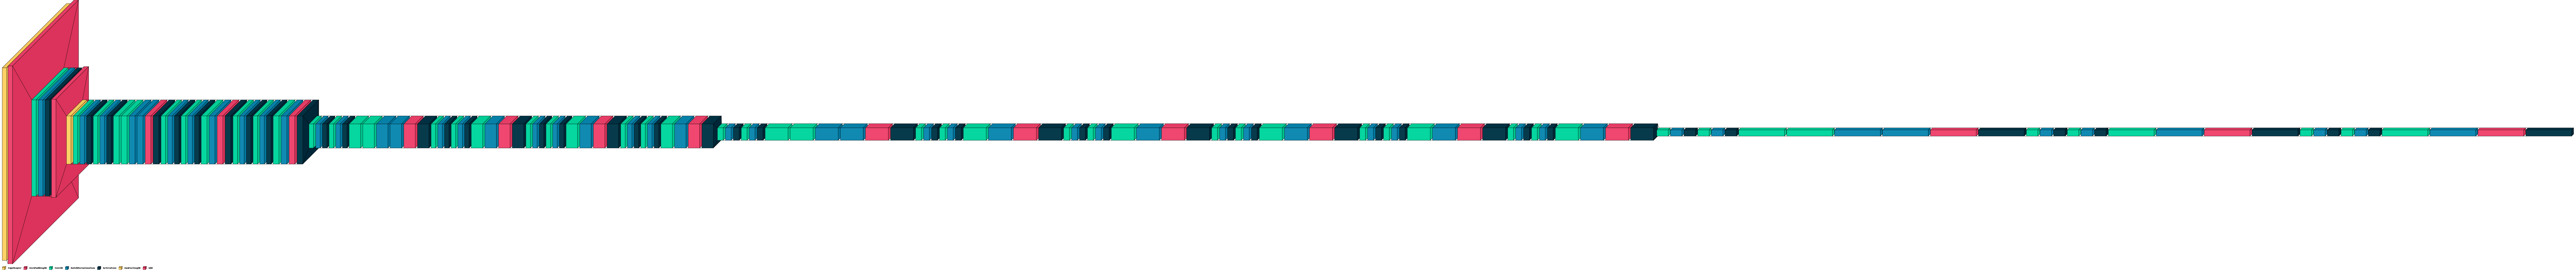

In [ ]:
from keras.applications import ResNet50
from keras.applications.resnet import preprocess_input as ResNet50_preprocess_input

target_shape = X_mel_train.shape[1:]
resnet50 = ResNet50(include_top = False, weights = "imagenet", input_shape = target_shape)

resnet50.summary()
visualkeras.layered_view(resnet50, legend = True)

In [ ]:
trim_layer = 'conv5_block3_out'
resnet50_basenet = freeze_model(trim_model(resnet50, trim_layer), freeze_until_layer='conv5_block2_out')

inputs = Input(shape = target_shape)
model = build_input_section(inputs, ResNet50_preprocess_input, False, True)
model = resnet50_basenet(model)
outputs = build_output_section(model, n_classes)

resnet50_net_mel = Model(inputs, outputs)

resnet50_net_mel.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 216, 216, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 216, 216, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 216, 216, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 216, 216, 3)      0         
                                                                 
 model_3 (Functional)        (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                    

In [ ]:
resnet50_net_mel.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor = "val_loss",
        min_delta = 0,
        patience = 150,
        restore_best_weights = True
    )
]

resnet50_net_mel_hist = resnet50_net_mel.fit(X_mel_train, y_mel_train,
                                         validation_split = 0.1,
                                         epochs = 150,
                                         batch_size=64,
                                         callbacks = callbacks)

Epoch 1/150
113/113 [==============================] - 43s 321ms/step - loss: 6.0014 - accuracy: 0.4730 - val_loss: 3.4160 - val_accuracy: 0.5100
Epoch 2/150
113/113 [==============================] - 37s 325ms/step - loss: 2.2031 - accuracy: 0.5855 - val_loss: 1.8497 - val_accuracy: 0.5925
Epoch 3/150
113/113 [==============================] - 38s 335ms/step - loss: 1.6571 - accuracy: 0.6196 - val_loss: 1.6482 - val_accuracy: 0.5813
Epoch 4/150
113/113 [==============================] - 36s 321ms/step - loss: 1.3992 - accuracy: 0.6506 - val_loss: 1.3193 - val_accuracy: 0.6637
Epoch 5/150
113/113 [==============================] - 38s 336ms/step - loss: 1.2717 - accuracy: 0.6667 - val_loss: 1.4299 - val_accuracy: 0.5987
Epoch 6/150
113/113 [==============================] - 32s 285ms/step - loss: 1.2080 - accuracy: 0.6810 - val_loss: 1.2430 - val_accuracy: 0.6413
Epoch 7/150
113/113 [==============================] - 32s 287ms/step - loss: 1.1495 - accuracy: 0.6916 - val_loss: 1.2180 -

In [ ]:
plot_history(resnet50_net_mel_hist)

In [ ]:
resnet50_net_mel.evaluate(X_mel_test,y_mel_test)

63/63 [==============================] - 7s 104ms/step - loss: 0.9527 - accuracy: 0.7838


[0.9527255296707153, 0.7837837934494019]

## CNN on Chroma Spectrogram

In [ ]:
chr_path = '/content/drive/MyDrive/Progetto/Audio_files/chromagram'

In [ ]:
image = cv2.imread(chr_path + '/test/chroma_test_00000_7.jpg',cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

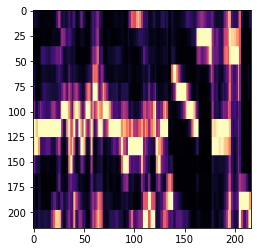

In [ ]:
plt.imshow(image)

In [ ]:
# CHR TRAIN DATASET
X_chr_train = []
y_chr_train = []
for path in glob.glob(chr_path + '/train/*'):
    lbl = path.split("/")[-1].split('.')[0].split('_')[-1]
    image = cv2.imread(path,cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    X_chr_train.append(image)
    y_chr_train.append(lbl)

X_chr_train = np.array(X_chr_train)
y_chr_train = np.array(y_chr_train)
y_chr_train = keras.utils.to_categorical(y_chr_train, n_classes)

In [ ]:
# CHR TEST DATASET
X_chr_test = []
y_chr_test = []
for path in glob.glob(chr_path + '/test/*'):
    lbl = path.split("/")[-1].split('.')[0].split('_')[-1]
    image = cv2.imread(path,cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    X_chr_test.append(image)
    y_chr_test.append(lbl)

X_chr_test = np.array(X_chr_test)
y_chr_test = np.array(y_chr_test)
y_chr_test = keras.utils.to_categorical(y_chr_test, 10)

In [ ]:
X_chr_train.shape

(7992, 216, 216, 3)

In [ ]:
_= save_pkl('XYtraintest_chr_split10_notnorm.pickle',(X_chr_train,y_chr_train,X_chr_test,y_chr_test))

In [ ]:
input_shape=X_chr_train.shape[1:]
model = keras.Sequential()

X_input = Input(input_shape)
X_input = Rescaling(1./255)(X_input)

X = Conv2D(16,kernel_size=(3,3), strides = (1,1), kernel_regularizer = regularizers.l2(), bias_regularizer= regularizers.l2())(X_input)
X = keras.layers.BatchNormalization(axis=3)(X)
X = keras.layers.Activation('relu')(X)
X = keras.layers.MaxPooling2D((2,2))(X)

X = Dropout(0.35)(X)

X = Conv2D(32,kernel_size=(3,3), kernel_regularizer = regularizers.l2(), bias_regularizer= regularizers.l2())(X)
X = keras.layers.BatchNormalization(axis=-1)(X)
X = keras.layers.Activation('relu')(X)
X = keras.layers.MaxPooling2D((2,2))(X)

X = Dropout(0.35)(X)

X = Conv2D(64,kernel_size=(3,3), kernel_regularizer = regularizers.l2(), bias_regularizer= regularizers.l2())(X)
X = keras.layers.BatchNormalization(axis=-1)(X)
X = keras.layers.Activation('relu')(X)
X = keras.layers.MaxPooling2D((2,2))(X)

X = Flatten()(X)

X = Dense(128, activation='relu', kernel_regularizer = regularizers.l2(), bias_regularizer= regularizers.l2())(X)
X = Dropout(0.2)(X)
X = Dense(64, activation='relu', kernel_regularizer = regularizers.l2(), bias_regularizer= regularizers.l2())(X)
X = Dropout(0.2)(X)
X = Dense(32, activation='relu', kernel_regularizer = regularizers.l2(), bias_regularizer= regularizers.l2())(X)

X = Dense(n_classes, activation='softmax')(X)

CNN_chr_net = Model(inputs=X_input, outputs=X)

In [ ]:
CNN_chr_net.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 216, 216, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 214, 214, 64)      1792      
                                                                 
 batch_normalization_2 (Batc  (None, 214, 214, 64)     256       
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 214, 214, 64)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 107, 107, 64)     0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 107, 107, 64)      0   

In [ ]:
CNN_chr_net.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor = "val_loss",
        min_delta = 0,
        patience = 100,
        restore_best_weights = True
    )
]

CNN_chr_net_hist = CNN_chr_net.fit(X_chr_train, y_chr_train,
                    epochs = 100,  
                    validation_split = 0.1,
                    batch_size = 32, 
                    shuffle = False,
                    callbacks = [callbacks])

Epoch 1/100
225/225 [==============================] - 11s 42ms/step - loss: 5.7550 - accuracy: 0.1221 - val_loss: 3.5891 - val_accuracy: 0.1088
Epoch 2/100
225/225 [==============================] - 9s 40ms/step - loss: 3.1280 - accuracy: 0.1460 - val_loss: 3.0152 - val_accuracy: 0.0950
Epoch 3/100
225/225 [==============================] - 9s 39ms/step - loss: 2.6983 - accuracy: 0.1881 - val_loss: 3.0943 - val_accuracy: 0.1013
Epoch 4/100
225/225 [==============================] - 9s 41ms/step - loss: 2.5279 - accuracy: 0.2111 - val_loss: 2.9486 - val_accuracy: 0.1025
Epoch 5/100
225/225 [==============================] - 9s 40ms/step - loss: 2.4129 - accuracy: 0.2226 - val_loss: 2.8357 - val_accuracy: 0.1287
Epoch 6/100
225/225 [==============================] - 9s 40ms/step - loss: 2.3340 - accuracy: 0.2311 - val_loss: 2.5828 - val_accuracy: 0.1600
Epoch 7/100
225/225 [==============================] - 9s 40ms/step - loss: 2.3065 - accuracy: 0.2353 - val_loss: 2.2264 - val_accuracy

In [ ]:
plot_history(CNN_chr_net_hist)

In [ ]:
CNN_chr_net.evaluate(X_chr_test, y_chr_test)

63/63 [==============================] - 1s 15ms/step - loss: 2.2351 - accuracy: 0.2863


[2.235114097595215, 0.28628629446029663]

### Resnet50 Chroma

94765736/94765736 [==============================] - 5s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 216, 216, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 222, 222, 3)  0           ['input_15[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 108, 108, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

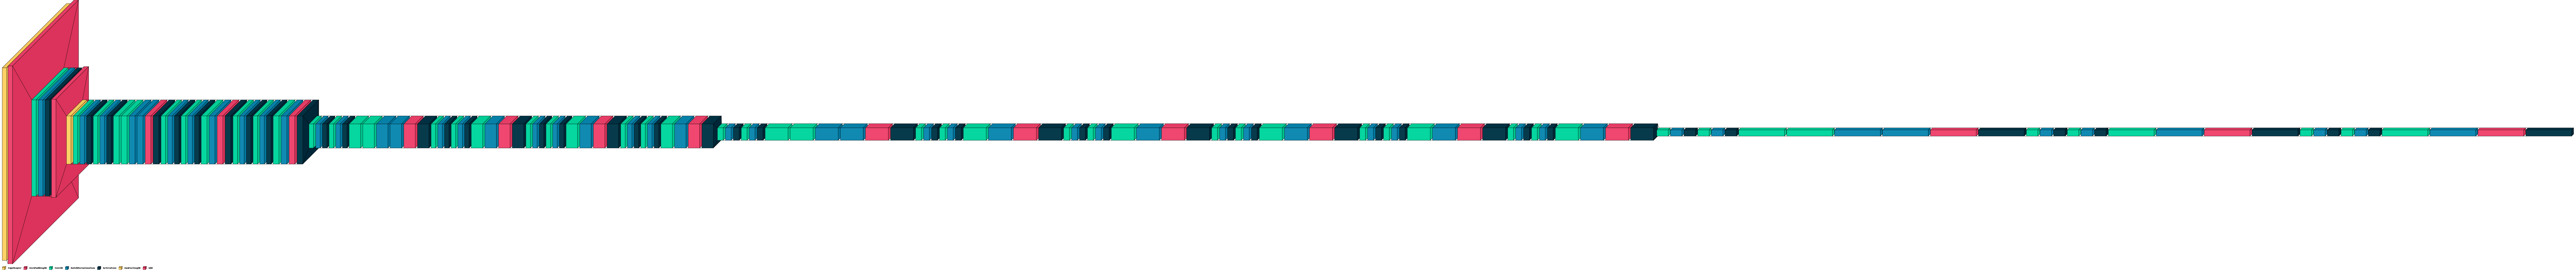

In [ ]:
from keras.applications import ResNet50
from keras.applications.resnet import preprocess_input as ResNet50_preprocess_input

target_shape = X_chr_train.shape[1:]
resnet50 = ResNet50(include_top = False, weights = "imagenet", input_shape = target_shape)

resnet50.summary()
visualkeras.layered_view(resnet50, legend = True)

In [ ]:
trim_layer = 'conv5_block3_out'
resnet50_basenet = freeze_model(trim_model(resnet50, trim_layer), freeze_until_layer='conv4_block3_out')

inputs = Input(shape = target_shape)
model = build_input_section(inputs, ResNet50_preprocess_input, False, True)
model = resnet50_basenet(model)
outputs = build_output_section(model, n_classes)

resnet50_net_chr = Model(inputs, outputs)

resnet50_net_chr.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 216, 216, 3)]     0         
                                                                 
 sequential_7 (Sequential)   (None, 216, 216, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 216, 216, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 216, 216, 3)      0         
                                                                 
 model_7 (Functional)        (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                    

In [ ]:
resnet50_net_chr.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor = "val_loss",
        min_delta = 0,
        patience = 150,
        restore_best_weights = True
    )
]

resnet50_net_chr_hist = resnet50_net_chr.fit(X_chr_train, y_chr_train,
                                         validation_split = 0.1,
                                         epochs = 150,
                                         batch_size=32,
                                         callbacks = callbacks)

Epoch 1/150
225/225 [==============================] - 56s 218ms/step - loss: 5.1127 - accuracy: 0.2424 - val_loss: 3.6951 - val_accuracy: 0.2025
Epoch 2/150
225/225 [==============================] - 48s 213ms/step - loss: 2.1049 - accuracy: 0.3429 - val_loss: 1.9025 - val_accuracy: 0.3625
Epoch 3/150
225/225 [==============================] - 47s 210ms/step - loss: 1.8752 - accuracy: 0.3699 - val_loss: 1.8873 - val_accuracy: 0.3862
Epoch 4/150
225/225 [==============================] - 47s 210ms/step - loss: 1.7785 - accuracy: 0.4053 - val_loss: 1.8893 - val_accuracy: 0.3750
Epoch 5/150
225/225 [==============================] - 47s 210ms/step - loss: 1.7449 - accuracy: 0.4074 - val_loss: 1.7410 - val_accuracy: 0.3913
Epoch 6/150
225/225 [==============================] - 48s 212ms/step - loss: 1.6952 - accuracy: 0.4302 - val_loss: 1.6209 - val_accuracy: 0.4462
Epoch 7/150
225/225 [==============================] - 48s 212ms/step - loss: 1.6791 - accuracy: 0.4352 - val_loss: 1.6495 -

In [ ]:
plot_history(resnet50_net_chr_hist)

In [ ]:
resnet50_net_chr.evaluate(X_chr_test,y_chr_test)

63/63 [==============================] - 8s 104ms/step - loss: 1.7829 - accuracy: 0.5506


[1.7829499244689941, 0.5505505800247192]

## Evaluation

63/63 [==============================] - 2s 24ms/step
              precision    recall  f1-score   support

           0       0.60      0.58      0.59       200
           1       0.62      0.69      0.65       200
           2       0.54      0.77      0.64       200
           3       0.83      0.66      0.73       198
           4       0.48      0.55      0.51       200
           5       0.96      0.63      0.76       200
           6       0.67      0.64      0.65       200
           7       0.63      0.68      0.66       200
           8       0.72      0.92      0.80       200
           9       0.86      0.51      0.64       200

    accuracy                           0.66      1998
   macro avg       0.69      0.66      0.66      1998
weighted avg       0.69      0.66      0.66      1998



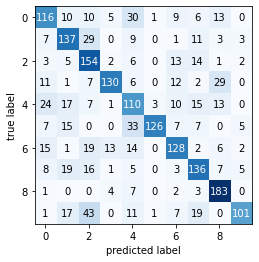

In [ ]:
# CNN on Mel 
y_mel_pred = CNN_mel_net.predict(X_test_mel)

print(classification_report(np.argmax(y_test_mel, axis=1), np.argmax(y_mel_pred, axis=1)))
cm = confusion_matrix(np.argmax(y_test_mel, axis=1), np.argmax(y_mel_pred, axis=1))
_ = plot_confusion_matrix(cm)

63/63 [==============================] - 9s 103ms/step
              precision    recall  f1-score   support

           0       0.88      0.57      0.70       200
           1       0.70      0.81      0.75       200
           2       0.78      0.80      0.79       200
           3       0.74      0.93      0.83       198
           4       0.58      0.78      0.67       200
           5       0.96      0.86      0.91       200
           6       0.70      0.85      0.77       200
           7       0.87      0.62      0.73       200
           8       0.90      0.98      0.94       200
           9       0.96      0.61      0.75       200

    accuracy                           0.78      1998
   macro avg       0.81      0.78      0.78      1998
weighted avg       0.81      0.78      0.78      1998



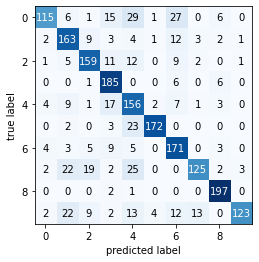

In [ ]:
# ResNet50 on Mel
y_mel_pred = resnet50_net_mel.predict(X_test_mel)

print(classification_report(np.argmax(y_test_mel, axis=1), np.argmax(y_mel_pred, axis=1)))
cm = confusion_matrix(np.argmax(y_test_mel, axis=1), np.argmax(y_mel_pred, axis=1))
_ = plot_confusion_matrix(cm)

63/63 [==============================] - 2s 11ms/step
              precision    recall  f1-score   support

           0       0.75      0.67      0.71       200
           1       0.18      0.60      0.28       200
           2       0.50      0.37      0.42       200
           3       0.25      0.14      0.18       200
           4       0.00      0.00      0.00       200
           5       0.16      0.02      0.04       200
           6       0.20      0.47      0.28       200
           7       0.16      0.23      0.18       200
           8       0.74      0.12      0.21       200
           9       0.65      0.24      0.35       198

    accuracy                           0.29      1998
   macro avg       0.36      0.29      0.27      1998
weighted avg       0.36      0.29      0.27      1998



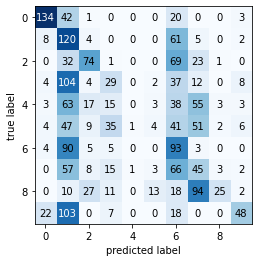

In [ ]:
# CNN on Chroma
y_chr_pred = CNN_chr_net.predict(X_test_chr)

print(classification_report(np.argmax(y_test_chr, axis=1), np.argmax(y_chr_pred, axis=1)))
cm = confusion_matrix(np.argmax(y_test_chr, axis=1), np.argmax(y_chr_pred, axis=1))
_ = plot_confusion_matrix(cm)

63/63 [==============================] - 7s 96ms/step
              precision    recall  f1-score   support

           0       0.73      0.97      0.84       200
           1       0.63      0.41      0.50       200
           2       0.82      0.39      0.53       200
           3       0.30      0.59      0.40       200
           4       0.41      0.61      0.49       200
           5       0.71      0.56      0.63       200
           6       0.38      0.24      0.30       200
           7       0.47      0.46      0.46       200
           8       0.80      0.55      0.65       200
           9       0.74      0.71      0.73       198

    accuracy                           0.55      1998
   macro avg       0.60      0.55      0.55      1998
weighted avg       0.60      0.55      0.55      1998



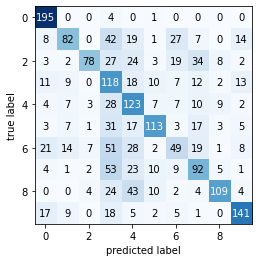

In [ ]:
# ResNet50 on Chroma
y_chr_pred = resnet50_net_chr.predict(X_test_chr)

print(classification_report(np.argmax(y_test_chr, axis=1), np.argmax(y_chr_pred, axis=1)))
cm = confusion_matrix(np.argmax(y_test_chr, axis=1), np.argmax(y_chr_pred, axis=1))
_ = plot_confusion_matrix(cm)

#Double input


In [ ]:
from skimage import io

In [ ]:
base_path = '/content/drive/MyDrive/Progetto/Audio_files/'

mel_fns = os.listdir(base_path+'mel_spectrograms/train')
mel_fns.sort()
chroma_fns = os.listdir(base_path+'chromagram/train')
chroma_fns.sort()

In [ ]:
fn_mel = np.stack([base_path+'mel_spectrograms/train/'+fn for fn in mel_fns])
fn_chrome = np.stack([base_path+'chromagram/train/'+fn for fn in  chroma_fns])

In [ ]:
labels = np.stack([tl[-5] for tl in fn_mel])
labels_cat = keras.utils.to_categorical(labels, 10)

In [ ]:
x_train_mel, x_val_mel, y_train, y_val = train_test_split(fn_mel, labels, test_size=0.2, stratify=labels, random_state=cherrypicked_seed)
x_train_chroma, x_val_chroma, _, _ = train_test_split(fn_chrome, labels, test_size=0.2, stratify=labels, random_state=cherrypicked_seed)

In [ ]:
y_train_cat = keras.utils.to_categorical(y_train,10)
y_val_cat = keras.utils.to_categorical(y_val,10)

In [ ]:
def imresize(img, size=(226,226), interp=cv2.INTER_LINEAR):
  return cv2.resize(img, dsize=size, interpolation=interp)

In [ ]:
class My_Custom_Generator(keras.utils.Sequence):
  
  def __init__(self, mel_filenames, chroma_filenames, labels, batch_size) :
    self.mel_filenames = mel_filenames
    self.chroma_filenames = chroma_filenames
    self.labels = labels
    self.batch_size = batch_size
    
    
  def __len__(self) :
    return (np.ceil(len(self.mel_filenames) / float(self.batch_size))).astype(np.int)
  
  
  def __getitem__(self, idx) :
    batch_x_mel = self.mel_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_x_chroma = self.chroma_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]

    # item = np.stack([
    #           np.stack([imresize(io.imread(str(file_name)), (224, 224)) for file_name in batch_x_mel]),
    #           np.stack([imresize(io.imread(str(file_name)), (224, 224)) for file_name in batch_x_chroma])
    #        ])
    return [np.stack([imresize(io.imread(str(file_name)), (224, 224)) for file_name in batch_x_mel]), np.stack([imresize(io.imread(str(file_name)), (224, 224)) for file_name in batch_x_chroma])], np.array(batch_y)

In [ ]:
my_training_batch_generator = My_Custom_Generator(x_train_mel, x_train_chroma, y_train_cat, batch_size=32)
my_val_batch_generator = My_Custom_Generator(x_val_mel, x_val_chroma, y_val_cat, batch_size=32) 

In [ ]:
step_val = my_val_batch_generator.__len__()
step_train = my_training_batch_generator.__len__()

<ipython-input-23-34904ebcd12e>:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return (np.ceil(len(self.mel_filenames) / float(self.batch_size))).astype(np.int)


In [ ]:
target_shape = (224,224,3)

In [ ]:
n_classes=10

In [ ]:
def build_siamese_output_section(inputs):
  x = layers.GlobalAveragePooling2D()(inputs) 
  outputs = Flatten()(x)
  return outputs

In [ ]:
from keras.applications import ResNet50
from keras.applications.resnet import preprocess_input as ResNet50_preprocess_input

resnet50 = ResNet50(include_top = False, weights = "imagenet", input_shape = target_shape)

trim_layer = 'conv5_block3_out'
resnet50_basenet_mel = freeze_model(trim_model(resnet50, trim_layer), freeze_until_layer='conv4_block6_out')
resnet50_basenet_chroma = freeze_model(trim_model(resnet50, trim_layer), freeze_until_layer='conv4_block3_out')

inputs_mel = Input(shape = target_shape)
model_mel = build_input_section(inputs_mel, ResNet50_preprocess_input, False, False)
model_mel = resnet50_basenet_mel(model_mel)
outputs_mel = build_siamese_output_section(model_mel)
resnet50_embedding_net_mel = Model(inputs_mel, outputs_mel)

inputs_chroma = Input(shape = target_shape)
model_chroma = build_input_section(inputs_chroma, ResNet50_preprocess_input, False, False)
model_chroma = resnet50_basenet_chroma(model_chroma)
outputs_chroma = build_siamese_output_section(model_chroma)
resnet50_embedding_net_chroma = Model(inputs_chroma, outputs_chroma)

In [ ]:
input_mel = layers.Input(target_shape)
input_chroma = layers.Input(target_shape)

tower_mel = resnet50_embedding_net_mel(input_chroma)
tower_chroma = resnet50_embedding_net_chroma(input_chroma)

merge_layer = keras.layers.Concatenate()([tower_mel, tower_chroma])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)


X = Dense(512, activation='relu', kernel_regularizer = regularizers.l2(), bias_regularizer= regularizers.l2())(normal_layer)
X = Dropout(0.2)(X)
X = Dense(256, activation='relu', kernel_regularizer = regularizers.l2(), bias_regularizer= regularizers.l2())(X)
X = Dropout(0.1)(X)
X = Dense(128, activation='relu', kernel_regularizer = regularizers.l2(), bias_regularizer= regularizers.l2())(X)
X = Dropout(0.1)(X)
X = Dense(64, activation='relu', kernel_regularizer = regularizers.l2(), bias_regularizer= regularizers.l2())(X)

output_layer = layers.Dense(n_classes, activation="softmax")(X)
siamese = keras.Model(inputs=[input_mel, input_chroma], outputs=output_layer)

In [ ]:
siamese.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_7 (Functional)           (None, 2048)         23587712    ['input_10[0][0]']               
                                                                                                  
 model_8 (Functional)           (None, 2048)         23587712    ['input_10[0][0]']               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 4096)         0           ['model_7[0][0]',          

In [ ]:
siamese.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor = "val_loss",
        min_delta = 0,
        patience = 10,
        restore_best_weights = True
    )
]

siamese_hist = siamese.fit(
                    my_training_batch_generator,
                    steps_per_epoch=step_train,
                    epochs = 20,  
                    validation_data = my_val_batch_generator,
                    validation_steps = step_val,
                    #batch_size = 32, 
                    shuffle = False,
                    )

<ipython-input-33-34904ebcd12e>:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return (np.ceil(len(self.mel_filenames) / float(self.batch_size))).astype(np.int)


Epoch 1/20
200/200 [==============================] - 100s 426ms/step - loss: 8.6070 - accuracy: 0.3413 - val_loss: 4.2654 - val_accuracy: 0.3308
Epoch 2/20
200/200 [==============================] - 85s 423ms/step - loss: 3.1691 - accuracy: 0.4439 - val_loss: 2.7485 - val_accuracy: 0.4178
Epoch 3/20
200/200 [==============================] - 85s 425ms/step - loss: 2.2820 - accuracy: 0.5104 - val_loss: 2.5155 - val_accuracy: 0.4128
Epoch 4/20
200/200 [==============================] - 85s 425ms/step - loss: 1.8306 - accuracy: 0.5858 - val_loss: 2.2312 - val_accuracy: 0.4565
Epoch 5/20
200/200 [==============================] - 85s 423ms/step - loss: 1.5889 - accuracy: 0.6318 - val_loss: 2.1795 - val_accuracy: 0.4478
Epoch 6/20
200/200 [==============================] - 86s 428ms/step - loss: 1.4103 - accuracy: 0.6881 - val_loss: 4.1410 - val_accuracy: 0.3565
Epoch 7/20
200/200 [==============================] - 85s 424ms/step - loss: 1.2283 - accuracy: 0.7353 - val_loss: 2.1102 - val_a

In [ ]:
siamese.save(base_path_tommaso + 'resnet50_doubleinput_mel_chroma_20epc')
save_pkl(base_path_tommaso + 'resnet50_hist_doubleinput_mel_chroma_20epc.pickle', siamese_hist)

## continue from 20epc

In [ ]:
base_path

'/content/drive/MyDrive/Colab Notebooks/DSIM/Audio files/'

In [ ]:
siamese = keras.models.load_model(base_path + 'resnet50_doubleinput_mel_chroma_20epc')

In [ ]:
siamese_hist_20epc = load_pkl(base_path + 'resnet50_hist_doubleinput_mel_chroma_20epc.pickle')

In [ ]:
siamese.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor = "val_loss",
        min_delta = 0,
        patience = 3,
        restore_best_weights = True
    )
]

start_finetune_epoch = siamese_hist_20epc.epoch[-1]
initial_epochs = len(siamese_hist_20epc.epoch)
total_epochs = initial_epochs+10

resnet50_net_finetune_hist = siamese.fit(my_training_batch_generator,
                                        steps_per_epoch=step_train,
                                        validation_data = my_val_batch_generator,
                                        validation_steps = step_val,
                                        epochs=total_epochs,
                                        initial_epoch=start_finetune_epoch)

<ipython-input-23-34904ebcd12e>:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return (np.ceil(len(self.mel_filenames) / float(self.batch_size))).astype(np.int)


Epoch 20/30
200/200 [==============================] - 4004s 20s/step - loss: 0.4958 - accuracy: 0.9548 - val_loss: 2.3277 - val_accuracy: 0.5410
Epoch 21/30
200/200 [==============================] - 76s 381ms/step - loss: 0.4600 - accuracy: 0.9607 - val_loss: 2.4568 - val_accuracy: 0.5153
Epoch 22/30
200/200 [==============================] - 78s 389ms/step - loss: 0.5247 - accuracy: 0.9521 - val_loss: 2.5966 - val_accuracy: 0.5166
Epoch 23/30
200/200 [==============================] - 78s 390ms/step - loss: 0.4561 - accuracy: 0.9692 - val_loss: 2.0633 - val_accuracy: 0.5616
Epoch 24/30
200/200 [==============================] - 79s 397ms/step - loss: 0.3325 - accuracy: 0.9794 - val_loss: 2.0347 - val_accuracy: 0.5716
Epoch 25/30
200/200 [==============================] - 80s 397ms/step - loss: 0.3063 - accuracy: 0.9844 - val_loss: 2.1985 - val_accuracy: 0.5622
Epoch 26/30
200/200 [==============================] - 79s 395ms/step - loss: 0.2996 - accuracy: 0.9819 - val_loss: 2.2122 -

In [ ]:
siamese.save(base_path + 'resnet50_doubleinput_mel_chroma_30epc')
save_pkl(base_path + 'resnet50_hist_doubleinput_mel_chroma_30epc.pickle', resnet50_net_finetune_hist)

#Backup pickle models

##Save

In [ ]:
#SVM on MFCC
_ = save_pkl('SVM_mfcc.pickle', clf_MFCC)
#SVM on MEL
_ = save_pkl('SVM_mel.pickle', clf_MEL)  
#SVM on CHROMA
_ = save_pkl('SVM_chroma.pickle', clf_CHR)
#SVM on MEL + CHROMA
_ = save_pkl('SVM_comb.pickle', clf_COMB)  

In [ ]:
# CNN_mel_net
_ = save_pkl('CNN_mel_net.pickle', CNN_mel_net) 
_ = save_pkl('CNN_mel_net_hist.pickle', CNN_mel_net_hist) 
_ = save_pkl('resnet50_net_mel.pickle', resnet50_net_mel)
_ = save_pkl('resnet50_net_mel_hist.pickle', resnet50_net_mel_hist)

#CNN_chr_net 
_ = save_pkl('CNN_chr_net.pickle', CNN_chr_net)
_ = save_pkl('CNN_chr_net_hist.pickle', CNN_chr_net_hist)
_ = save_pkl('resnet50_net_chr.pickle', resnet50_net_chr)
_ = save_pkl('resnet50_net_chr_hist.pickle', resnet50_net_chr_hist)

##Load

In [ ]:
# Base path to pickle objects - modify with yours
folder_path = '/content/drive/MyDrive/Progetto/Audio_files/Audio_pickle/'

FEATURES

In [ ]:
# MFCC
X_train_mfcc, X_test_mfcc, y_train_mfcc, y_test_mfcc = load_pkl(folder_path +'XYtraintest_mfcc_split10.pickle')

In [ ]:
# MEL
X_train_mel, X_test_mel, y_train_mel, y_test_mel = load_pkl(folder_path +'XYtraintest_mel_split10.pickle')

In [ ]:
# CHROMA
X_train_chr, X_test_chr, y_train_chr, y_test_chr = load_pkl(folder_path +'XYtraintest_chr_split10.pickle')

In [ ]:
# MEL + CHROMA
X_train_comb, X_test_comb, y_train_comb, y_test_comb = load_pkl(folder_path +'XYtraintest_comb_split10.pickle')

In [ ]:
# CNN UN-NORMALIZED FEATURES
X_train_mel, y_train_mel, X_test_mel, y_test_mel = load_pkl(folder_path +'XYtraintest_mel_split10_notnorm.pickle') # MEL
X_train_chr, y_train_chr, X_test_chr, y_test_chr = load_pkl(folder_path +'XYtraintest_chr_split10_notnorm.pickle') # CHROMA

MODELS

In [ ]:
# SVM on MFCC
clf_MFCC = load_pkl(folder_path +'SVM_mfcc.pickle')
# SVM on MEL
clf_MEL = load_pkl(folder_path +'SVM_mel.pickle')  
# SVM on CHROMA
clf_CHR = load_pkl(folder_path +'SVM_chroma.pickle')
# SVM on MEL + CHROMA
clf_COMB = load_pkl(folder_path +'SVM_comb.pickle')

In [ ]:
# CNN_mel_net
CNN_mel_net = load_pkl(folder_path +'CNN_mel_net.pickle') 
CNN_mel_net_hist = load_pkl(folder_path +'CNN_mel_net_hist.pickle') 
resnet50_net_mel = load_pkl(folder_path +'resnet50_net_mel.pickle')
resnet50_net_mel_hist = load_pkl(folder_path +'resnet50_net_mel_hist.pickle')

# CNN_chr_net 
CNN_chr_net = load_pkl(folder_path +'CNN_chr_net.pickle')
CNN_chr_net_hist = load_pkl(folder_path +'CNN_chr_net_hist.pickle')
resnet50_net_chr = load_pkl(folder_path +'resnet50_net_chr.pickle')
resnet50_net_chr_hist = load_pkl(folder_path +'resnet50_net_chr_hist.pickle')